# Flatiron Health mCRC: Strict trials with GBM crude 

***OBJECTIVE:*** **Inclusion criteria for trials in other notebooks were relaxed to allow for as many patients to be included as reasonably possible. In this notebook, inclusion criteria for the trials will be followed as closely as possible. Patients included in our trials will next be risk stratified using the gradient boosted model with crude imputation into 1 of 3 risk groups: high (top tertile), medium (middle tertile), and low (bottom tertile). Inverse-probability treatment weighted survival analysis will then be performed across these risk groups to get real-world estimates of survival while adjusting for measured confounders.**  

***OUTLINE:***
1. **Identify patients with exclusion criteria:**
* Relevant comorbidities in the year preceding metastatic diagnosis 
* CNS metastasis at time of treatment  
* ECOG 3 or 4 at time of treatment
* Organ dysfunction at time of treatment   

2. **In silico trial:**
* FIRE-3 

## Part 1: Identify patients with exclusion criteria

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Function that returns number of rows and count of unique PatientIDs for a dataframe. 
def row_ID(dataframe):
    row = dataframe.shape[0]
    ID = dataframe['PatientID'].nunique()
    return row, ID

In [3]:
train = pd.read_csv('train_full.csv')
row_ID(train)

(27452, 27452)

In [4]:
test = pd.read_csv('test_full.csv')
row_ID(test)

(6863, 6863)

In [5]:
df = pd.concat([train, test], ignore_index = True)
row_ID(df)

(34315, 34315)

### 1. Relevant comorbidities in the year preceding metastatic diagnosis 
* MI
* Severe psychiatric history 
* Drug use disorder 
* Inflammatory bowel disease
* Nephrotic syndrome 
* Uncontrolled hypertension
* Coagulopathy 
* Arterial or venous thrombosis
* Intracerebral hemmorrhage 

In [6]:
diagnosis = pd.read_csv('Diagnosis.csv')

In [7]:
diagnosis = diagnosis[diagnosis['PatientID'].isin(df['PatientID'])]       

In [8]:
diagnosis.loc[:, 'DiagnosisDate'] = pd.to_datetime(diagnosis['DiagnosisDate'])

In [9]:
enhanced_met = pd.read_csv('Enhanced_MetastaticCRC.csv')

In [10]:
enhanced_met.loc[:, 'MetDiagnosisDate'] = pd.to_datetime(enhanced_met['MetDiagnosisDate'])

In [11]:
row_ID(diagnosis)

(1088706, 34315)

In [12]:
diagnosis = pd.merge(diagnosis, enhanced_met[['PatientID', 'MetDiagnosisDate']], on = 'PatientID', how = 'left')

In [13]:
row_ID(diagnosis)

(1088706, 34315)

In [14]:
diagnosis.loc[:, 'date_diff'] = (diagnosis['DiagnosisDate'] - diagnosis['MetDiagnosisDate']).dt.days

In [15]:
diagnosis.loc[:, 'diagnosis_code'] = diagnosis['DiagnosisCode'].replace('\.', '', regex = True)

In [16]:
# ICD-9 dataframe with unique codes for each patient. 
diagnosis_9 = (
    diagnosis
    .query('date_diff <= 0 and date_diff > -365')
    .query('DiagnosisCodeSystem == "ICD-9-CM"')
    .drop_duplicates(subset = (['PatientID', 'DiagnosisCode']), keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [17]:
comorb_9_IDs = (
    diagnosis_9[diagnosis_9['diagnosis_code'].str.match('410|'
                                                        '29[5789]|'
                                                        '30[34]|'
                                                        '55[56]|'
                                                        '581|'
                                                        '4010|'
                                                        '286|'
                                                        '444|'
                                                        '4151|'
                                                        '451[1289]|'
                                                        '431')].PatientID.unique())

In [18]:
len(comorb_9_IDs)

190

In [19]:
# ICD-10 dataframe with unique codes for each patient. 
diagnosis_10 = (
    diagnosis
    .query('date_diff <= 0 and date_diff > -365')
    .query('DiagnosisCodeSystem == "ICD-10-CM"')
    .drop_duplicates(subset = (['PatientID', 'DiagnosisCode']), keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [20]:
comorb_10_IDs = (
    diagnosis_10[diagnosis_10['diagnosis_code'].str.match('I21|'
                                                          'F2[0234589]|'
                                                          'F1[0145]|'
                                                          'K5[01]|'
                                                          'N04|'
                                                          'I16|'
                                                          'D6[567]|'
                                                          'I74|'
                                                          'I82|'
                                                          'I6[01]')].PatientID.unique())

In [21]:
len(comorb_10_IDs)

418

In [22]:
comorb_IDs = np.unique(np.concatenate([comorb_9_IDs, comorb_10_IDs]))

In [23]:
len(comorb_IDs)

603

### 2. CNS metastasis at start of treatment 

In [24]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [25]:
line_therapy = line_therapy[line_therapy['PatientID'].isin(df['PatientID'])]       

In [26]:
line_therapy.loc[:, 'StartDate'] = pd.to_datetime(line_therapy['StartDate'])

In [27]:
therapy_fl = line_therapy.query('LineNumber == 1').query('IsMaintenanceTherapy == False')[['PatientID', 'StartDate']]

In [28]:
row_ID(diagnosis)

(1088706, 34315)

In [29]:
cns_fl = pd.merge(diagnosis, therapy_fl, on = 'PatientID', how = 'left')

In [30]:
row_ID(diagnosis)

(1088706, 34315)

In [31]:
cns_fl.loc[:, 'fl_date_diff'] = (cns_fl['DiagnosisDate'] - cns_fl['StartDate']).dt.days

In [32]:
# ICD-9 dataframe with unique codes for each patient. 
cns_fl_9 = (
    cns_fl
    .query('fl_date_diff <= 0 and fl_date_diff > -90')
    .query('DiagnosisCodeSystem == "ICD-9-CM"')
    .drop_duplicates(subset = (['PatientID', 'DiagnosisCode']), keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [33]:
cns_fl_9_ids = (
    cns_fl_9[cns_fl_9['diagnosis_code'].str.match('198[34]')].PatientID.unique()
)

In [34]:
len(cns_fl_9_ids)

34

In [35]:
# ICD-9 dataframe with unique codes for each patient. 
cns_fl_10 = (
    cns_fl
    .query('fl_date_diff <= 0 and fl_date_diff > -90')
    .query('DiagnosisCodeSystem == "ICD-10-CM"')
    .drop_duplicates(subset = (['PatientID', 'DiagnosisCode']), keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [36]:
cns_fl_10_ids = (
    cns_fl_10[cns_fl_10['diagnosis_code'].str.match('C79[34]')].PatientID.unique()
)

In [37]:
len(cns_fl_10_ids)

134

In [38]:
cns_fl_IDs = np.unique(np.concatenate([cns_fl_9_ids, cns_fl_10_ids]))

In [39]:
len(cns_fl_IDs)

165

### 3. ECOG 3 or 4 at start of treatment 

In [40]:
base_ecog = pd.read_csv('BaselineECOG.csv')

In [41]:
base_ecog = base_ecog[base_ecog['PatientID'].isin(df['PatientID'])]       

In [42]:
ecog_fl_IDs = (
    base_ecog
    .query('LineNumber == 1')
    .query('ECOGValue == "3" or ECOGValue == "4"')
    .PatientID.unique())

In [43]:
len(ecog_fl_IDs)

599

### 4. Abnormal organ function at start of treatment 
* Hemoglobin >9
* Creatinine <2
* Total bilirubin <3

In [44]:
lab = pd.read_csv('Lab.csv')

In [45]:
lab = lab[lab['PatientID'].isin(df['PatientID'])]

In [46]:
lab.loc[:, 'ResultDate'] = pd.to_datetime(lab['ResultDate']) 

In [47]:
row_ID(lab)

(30620401, 33014)

In [48]:
lab = pd.merge(lab, therapy_fl[['PatientID', 'StartDate']], on = 'PatientID', how = 'left')

In [49]:
row_ID(lab)

(31709973, 33014)

In [50]:
# Select rows with clinically relevant labs.
lab_core = (
    lab[
    (lab['LOINC'] == "2160-0") |
    (lab['LOINC'] == "38483-4") | 
    (lab['LOINC'] == "718-7") |
    (lab['LOINC'] == "20509-6") |
    (lab['LOINC'] == "42719-5") |
    (lab['LOINC'] == "1975-2")]
    .filter(items = ['PatientID', 
                     'ResultDate', 
                     'LOINC', 
                     'LabComponent', 
                     'TestUnits', 
                     'TestUnitsCleaned', 
                     'TestResult', 
                     'TestResultCleaned', 
                     'StartDate'])
)

In [51]:
conditions = [
    ((lab_core['LOINC'] == '2160-0') | (lab_core['LOINC'] == '38483-4')),
    ((lab_core['LOINC'] == '718-7') | (lab_core['LOINC'] == '20509-6')),
    ((lab_core['LOINC'] == '42719-5') | (lab_core['LOINC'] == '1975-2'))]

choices = ['creatinine', 
           'hemoglobin', 
           'total_bilirubin']

lab_core.loc[:, 'lab_name'] = np.select(conditions, choices)

In [52]:
row_ID(lab_core)

(3022972, 32769)

In [53]:
conditions = [
    (lab_core['lab_name'] == 'hemoglobin') & (lab_core['TestUnits'] == 'g/uL')]

choices = [lab_core['TestResultCleaned'] / 100000]

lab_core.loc[:, 'test_result_cleaned'] = np.select(conditions, choices, default = lab_core['TestResultCleaned'])

In [54]:
lab_f = (
    lab_core
    .assign(lab_date_diff = (lab_core['ResultDate'] - lab_core['StartDate']).dt.days)
    .query('lab_date_diff <= 0 and lab_date_diff > -90')
    .sort_values(by = ['PatientID', 'lab_name', 'lab_date_diff'], ascending = [True, True, False])
    .drop_duplicates(subset = ['PatientID', 'lab_name'], keep = 'first' )
)

In [55]:
# Select lab closest to date of advanced diagnosis and pivot to a wide table. 
lab_wide = (
    lab_f
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index())

lab_wide.columns.name = None

In [56]:
lab_wide.sample(3)

,PatientID,creatinine,hemoglobin,total_bilirubin
11644,F78FC65FAB596,0.65,10.8,NaN
17966,FBC7EF239BECA,NaN,9.6,NaN
24257,FFD98173E7880,0.80,13.1,0.5


In [57]:
ab_organ_IDs = lab_wide.query('creatinine > 2 or hemoglobin < 9 or total_bilirubin > 3').PatientID

In [58]:
len(ab_organ_IDs)

2363

In [59]:
ab_organ_IDs.to_csv('ab_organ_IDs.csv', index = False)

In [60]:
del base_ecog
del cns_fl_10
del cns_fl_9
del diagnosis
del diagnosis_10
del diagnosis_9
del enhanced_met
del lab
del lab_core
del lab_f
del lab_wide 
del line_therapy
del therapy_fl

## Part 2: In-silico trials 

### Import packages and create necessary functions

In [61]:
import numpy as np
import pandas as pd

from scipy import stats

from sksurv.nonparametric import kaplan_meier_estimator
from survive import KaplanMeier, SurvivalData

from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.utils import median_survival_times

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.linear_model import LogisticRegression

from matplotlib.lines import Line2D   

In [62]:
# Function that returns number of rows and count of unique PatientIDs for a dataframe. 
def row_ID(dataframe):
    row = dataframe.shape[0]
    ID = dataframe['PatientID'].nunique()
    return row, ID

In [63]:
cutoff = pd.read_csv('risk_cutoff_colorectal.csv', index_col = 0)

### FIRE-3: FOLFIRI plus cetuximab vs. FOLFIRI plus bevacizumab in KRAS wild-type 

**INCLUSION**
* Untreated metastatic colorectal cancer
* First-line recepit of FOLFIRI/FOLFOX plus cetuximab or FOLFIRI/FOLFOX plus bevacizumab 
* KRAS wild-type 
* No relevant comorbidities in the year preceding metastatic diagnosis 
* No CNS metastasis at time of treatment
* No ECOG 3 or 4 at time of treatment 
* Adequate organ function at time of treatment 

#### FOLFIRI plus Cetuximab

In [64]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

34315

In [65]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [66]:
line_therapy_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False'))

In [67]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('FOLFOX|Cetuximab')].LineName.value_counts().head(10)

FOLFOX,Bevacizumab            6338
FOLFOX                        4140
FOLFOX,Bevacizumab-Awwb       1356
FOLFOX,Bevacizumab-Bvzr        462
FOLFOX,Panitumumab             456
FOLFIRI,Cetuximab              364
FOLFOXIRI                      253
FOLFOX,Cetuximab               245
FOLFOXIRI,Bevacizumab          228
FOLFOXIRI,Bevacizumab-Awwb     140
Name: LineName, dtype: int64

In [68]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('FOLFIRI|Cetuximab')].LineName.value_counts().head(10)

FOLFIRI,Bevacizumab         2240
FOLFIRI                      914
FOLFIRI,Bevacizumab-Awwb     557
FOLFIRI,Cetuximab            364
FOLFIRI,Panitumumab          261
FOLFOX,Cetuximab             245
FOLFIRI,Bevacizumab-Bvzr     165
Irinotecan,Cetuximab          90
Cetuximab                     70
FOLFIRI,Ziv-Aflibercept       56
Name: LineName, dtype: int64

In [69]:
fxi_cet = (
    line_therapy_fl
    .query('LineName == "FOLFIRI,Cetuximab" or LineName == "FOLFOX,Cetuximab"')
    [['PatientID', 'StartDate']]
)

In [70]:
fxi_cet.loc[:,'fxi_cet'] = 1

In [71]:
row_ID(fxi_cet)

(609, 568)

In [72]:
fxi_cet['StartDate'] = pd.to_datetime(fxi_cet['StartDate'])

In [73]:
fxi_cet = (
    fxi_cet
    .sort_values(['PatientID', 'StartDate'], ascending = [True, True])
    .drop_duplicates(subset = 'PatientID', keep = 'first')
)

In [74]:
row_ID(fxi_cet)

(568, 568)

#### FOLFIRI plus Bevacizumab

In [75]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('FOLFIRI|Bevacizumab')].LineName.value_counts().head(10)

FOLFOX,Bevacizumab                     6338
FOLFIRI,Bevacizumab                    2240
FOLFOX,Bevacizumab-Awwb                1356
FOLFIRI                                 914
CAPEOX,Bevacizumab                      764
FOLFIRI,Bevacizumab-Awwb                557
FOLFOX,Bevacizumab-Bvzr                 462
Fluorouracil,Leucovorin,Bevacizumab     423
Capecitabine,Bevacizumab                405
FOLFIRI,Cetuximab                       364
Name: LineName, dtype: int64

In [76]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('FOLFOX|Bevacizumab')].LineName.value_counts().head(10)

FOLFOX,Bevacizumab                     6338
FOLFOX                                 4140
FOLFIRI,Bevacizumab                    2240
FOLFOX,Bevacizumab-Awwb                1356
CAPEOX,Bevacizumab                      764
FOLFIRI,Bevacizumab-Awwb                557
FOLFOX,Bevacizumab-Bvzr                 462
FOLFOX,Panitumumab                      456
Fluorouracil,Leucovorin,Bevacizumab     423
Capecitabine,Bevacizumab                405
Name: LineName, dtype: int64

In [77]:
fxi_bev_comb = [
    'FOLFIRI,Bevacizumab',
    'FOLFIRI,Bevacizumab-Awwb',
    'FOLFIRI,Bevacizumab-Bvzr',
    'FOLFOX,Bevacizumab',
    'FOLFOX,Bevacizumab-Awwb',
    'FOLFOX,Bevacizumab-Bvzr'
]

fxi_bev = (
    line_therapy_fl
    .query('LineName == @fxi_bev_comb')
    [['PatientID', 'StartDate']]
)

In [78]:
fxi_bev.loc[:,'fxi_cet'] = 0

In [79]:
row_ID(fxi_bev)

(11118, 10785)

In [80]:
fxi_bev['StartDate'] = pd.to_datetime(fxi_bev['StartDate'])

In [81]:
fxi_bev = (
    fxi_bev
    .sort_values(['PatientID', 'StartDate'], ascending = [True, True])
    .drop_duplicates(subset = 'PatientID', keep = 'first')
)

In [82]:
row_ID(fxi_bev)

(10785, 10785)

In [83]:
fire = pd.concat([fxi_cet, fxi_bev])

In [84]:
row_ID(fire)

(11353, 11353)

In [85]:
fire = pd.merge(fire, df_full, on = 'PatientID', how = 'inner')

In [86]:
row_ID(fire)

(11353, 11353)

#### KRAS wild type 

In [87]:
biomarkers = pd.read_csv('Enhanced_MetCRCBiomarkers.csv')

In [88]:
biomarkers = biomarkers[biomarkers['PatientID'].isin(fire['PatientID'])]

In [89]:
row_ID(biomarkers)

(46879, 10576)

In [90]:
biomarkers = pd.merge(biomarkers, fire[['PatientID', 'StartDate']], on = 'PatientID', how = 'left')

In [91]:
row_ID(biomarkers)

(46879, 10576)

In [92]:
biomarkers['ResultDate'] = pd.to_datetime(biomarkers['ResultDate'])

In [93]:
biomarkers['SpecimenReceivedDate'] = pd.to_datetime(biomarkers['SpecimenReceivedDate'])

In [94]:
biomarkers.loc[:, 'result_date'] = (
    np.where(biomarkers['ResultDate'].isna(), biomarkers['SpecimenReceivedDate'], biomarkers['ResultDate'])
)

In [95]:
biomarkers.loc[:, 'date_diff'] = (biomarkers['result_date'] - biomarkers['StartDate']).dt.days

In [96]:
kras = (
    biomarkers
    .query('BiomarkerName == "KRAS"')
    .query('date_diff <=30')
    .query('BiomarkerStatus == "Mutation negative"')
    [['PatientID', 'BiomarkerStatus']]
    .rename(columns = {'BiomarkerStatus': 'kras_n'})
    .drop_duplicates(subset = 'PatientID', keep = 'first')
)

In [97]:
row_ID(kras)

(3645, 3645)

In [98]:
fire = pd.merge(fire, kras, on  = 'PatientID', how = 'outer')

In [99]:
row_ID(fire)

(11353, 11353)

#### Time from treatment to death or censor 

In [100]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [101]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [102]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [103]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [104]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
print(len(mortality), mortality.PatientID.is_unique)

34315 True


In [105]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [106]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [107]:
len(mortality)

34315

In [108]:
fire = pd.merge(fire, mortality, on = 'PatientID')

In [109]:
len(fire)

11353

In [110]:
conditions = [
    (fire['death_status'] == 1),
    (fire['death_status'] == 0)]

choices = [
    (fire['death_date'] - fire['StartDate']).dt.days,
    (fire['last_activity'] - fire['StartDate']).dt.days]

fire.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

In [111]:
fire = fire.query('timerisk_treatment >= 0')

In [112]:
row_ID(fire)

(11343, 11343)

#### Patient count 

In [113]:
fire = fire.query('kras_n == "Mutation negative"')

In [114]:
row_ID(fire)

(3641, 3641)

In [115]:
# Exclude those with relevant comorbidities in the year preceding metastatic diagnosis 
fire = fire[~fire['PatientID'].isin(comorb_IDs)]

In [116]:
# Exlcude those with CNS metastasis at time of treatment 
fire = fire[~fire['PatientID'].isin(cns_fl_IDs)]

In [117]:
# Exclude those with ECOG 3 or 4 at time of treatment 
fire = fire[~fire['PatientID'].isin(ecog_fl_IDs)]

In [118]:
# Exclude those with abnormal organ function at time of treatment 
fire = fire[~fire['PatientID'].isin(ab_organ_IDs)]

In [119]:
row_ID(fire)

(3263, 3263)

In [120]:
low_cutoff_fire = cutoff.loc['fire3'].low

In [121]:
high_cutoff_fire = cutoff.loc['fire3'].high

In [122]:
print('FOLFIRI + Cetuximab total:',  fire.query('fxi_cet == 1').shape[0])
print('High risk:', fire.query('fxi_cet == 1').query('risk_score >= @high_cutoff_fire').shape[0])
print('Med risk:', fire.query('fxi_cet == 1').query('risk_score < @high_cutoff_fire and risk_score > @low_cutoff_fire').shape[0])
print('Low risk:', fire.query('fxi_cet == 1').query('risk_score <= @low_cutoff_fire').shape[0])

FOLFIRI + Cetuximab total: 450
High risk: 112
Med risk: 173
Low risk: 165


In [123]:
print('FOLFIRI + Bevacizumab:',  fire.query('fxi_cet == 0').shape[0])
print('High risk:', fire.query('fxi_cet == 0').query('risk_score >= @high_cutoff_fire').shape[0])
print('Med risk:', fire.query('fxi_cet == 0').query('risk_score < @high_cutoff_fire and risk_score > @low_cutoff_fire').shape[0])
print('Low risk:', fire.query('fxi_cet == 0').query('risk_score <= @low_cutoff_fire').shape[0])

FOLFIRI + Bevacizumab: 2813
High risk: 860
Med risk: 960
Low risk: 993


#### Survival curves with covariate balancing 

In [124]:
fire = fire.set_index('PatientID')

In [125]:
fire['met_cat'] = pd.cut(fire['met_year'],
                         bins = [2010, 2015, float('inf')],
                         labels = ['11-15', '16-22'])

In [126]:
conditions = [
    ((fire['ecog_diagnosis'] == "1.0") | (fire['ecog_diagnosis'] == "0.0")),  
    ((fire['ecog_diagnosis'] == "2.0") | (fire['ecog_diagnosis'] == "3.0"))
]

choices = ['lt_2', 'gte_2']

fire['ecog_2'] = np.select(conditions, choices, default = 'unknown')

In [127]:
fire_iptw = fire.filter(items = ['death_status',
                                 'timerisk_treatment',
                                 'fxi_cet',
                                 'age',
                                 'gender',
                                 'race',
                                 'p_type',
                                 'crc_site',
                                 'met_cat',
                                 'delta_met_diagnosis',
                                 'commercial',
                                 'medicare',
                                 'medicaid',
                                 'ecog_2', 
                                 'ses',
                                 'risk_score'])

In [128]:
fire_iptw.dtypes

death_status               bool
timerisk_treatment      float64
fxi_cet                   int64
age                       int64
gender                   object
race                     object
p_type                   object
crc_site                 object
met_cat                category
delta_met_diagnosis       int64
commercial              float64
medicare                float64
medicaid                float64
ecog_2                   object
ses                     float64
risk_score              float64
dtype: object

In [129]:
to_be_categorical = list(fire_iptw.select_dtypes(include = ['object']).columns)

In [130]:
to_be_categorical

['gender', 'race', 'p_type', 'crc_site', 'ecog_2']

In [131]:
to_be_categorical.append('met_cat')

In [132]:
to_be_categorical.append('ses')

In [133]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    fire_iptw[x] = fire_iptw[x].astype('category')

In [134]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age', 'delta_met_diagnosis']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [135]:
# List of categorical features.
categorical_features = list(fire_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [136]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [137]:
fire_iptw_low = (
    fire_iptw
    .query('risk_score <= @low_cutoff_fire')
    .drop(columns = ['risk_score']))

fire_iptw_med = (
    fire_iptw
    .query('risk_score < @high_cutoff_fire and risk_score > @low_cutoff_fire')
    .drop(columns = ['risk_score']))

fire_iptw_high = (
    fire_iptw
    .query('risk_score >= @high_cutoff_fire')
    .drop(columns = ['risk_score']))

fire_iptw_all = (
    fire_iptw
    .drop(columns = ['risk_score']))

In [138]:
fire_low_x = preprocessor.fit_transform(fire_iptw_low.filter(items = ['age',
                                                                      'gender',
                                                                      'race',
                                                                      'p_type',
                                                                      'crc_site',
                                                                      'met_cat',
                                                                      'delta_met_diagnosis',
                                                                      'commercial',
                                                                      'medicare',
                                                                      'medicaid',
                                                                      'ecog_2', 
                                                                      'ses']))

fire_med_x = preprocessor.fit_transform(fire_iptw_med.filter(items = ['age',
                                                                      'gender',
                                                                      'race',
                                                                      'p_type',
                                                                      'crc_site',
                                                                      'met_cat',
                                                                      'delta_met_diagnosis',
                                                                      'commercial',
                                                                      'medicare',
                                                                      'medicaid', 
                                                                      'ecog_2',
                                                                      'ses']))

fire_high_x = preprocessor.fit_transform(fire_iptw_high.filter(items = ['age',
                                                                        'gender',
                                                                        'race',
                                                                        'p_type',
                                                                        'crc_site',
                                                                        'met_cat',
                                                                        'delta_met_diagnosis',
                                                                        'commercial',
                                                                        'medicare',
                                                                        'medicaid',
                                                                        'ecog_2', 
                                                                        'ses']))

fire_all_x = preprocessor.fit_transform(fire_iptw_all.filter(items = ['age',
                                                                      'gender',
                                                                      'race',
                                                                      'p_type',
                                                                      'crc_site',
                                                                      'met_cat',
                                                                      'delta_met_diagnosis',
                                                                      'commercial',
                                                                      'medicare',
                                                                      'medicaid', 
                                                                      'ecog_2',
                                                                      'ses']))

In [139]:
lr_fire_low = LogisticRegression(max_iter = 1000)
lr_fire_low.fit(fire_low_x, fire_iptw_low['fxi_cet'])

LogisticRegression(max_iter=1000)

In [140]:
lr_fire_med = LogisticRegression(max_iter = 1000)
lr_fire_med.fit(fire_med_x, fire_iptw_med['fxi_cet'])

LogisticRegression(max_iter=1000)

In [141]:
lr_fire_high = LogisticRegression(max_iter = 1000)
lr_fire_high.fit(fire_high_x, fire_iptw_high['fxi_cet'])

LogisticRegression(max_iter=1000)

In [142]:
lr_fire_all = LogisticRegression(max_iter = 1000)
lr_fire_all.fit(fire_all_x, fire_iptw_all['fxi_cet'])

LogisticRegression(max_iter=1000)

In [143]:
pred_low = lr_fire_low.predict_proba(fire_low_x)
pred_med = lr_fire_med.predict_proba(fire_med_x)
pred_high = lr_fire_high.predict_proba(fire_high_x)
pred_all = lr_fire_all.predict_proba(fire_all_x)

In [144]:
fire_iptw_low['ps'] = pred_low[:, 1]
fire_iptw_med['ps'] = pred_med[:, 1]
fire_iptw_high['ps'] = pred_high[:, 1]
fire_iptw_all['ps'] = pred_all[:, 1]

In [145]:
fire_iptw_low['weight'] = (
    np.where(fire_iptw_low['fxi_cet'] == 1, 1/fire_iptw_low['ps'], 1/(1 - fire_iptw_low['ps'])))

fire_iptw_med['weight'] = (
    np.where(fire_iptw_med['fxi_cet'] == 1, 1/fire_iptw_med['ps'], 1/(1 - fire_iptw_med['ps'])))

fire_iptw_high['weight'] = (
    np.where(fire_iptw_high['fxi_cet'] == 1, 1/fire_iptw_high['ps'], 1/(1 - fire_iptw_high['ps'])))

fire_iptw_all['weight'] = (
    np.where(fire_iptw_all['fxi_cet'] == 1, 1/fire_iptw_all['ps'], 1/(1 - fire_iptw_all['ps'])))

In [146]:
# Low KM curves
kmf_low_cet_f_iptw = KaplanMeierFitter()
kmf_low_bev_f_iptw = KaplanMeierFitter()

kmf_low_cet_f_iptw.fit(
    fire_iptw_low.query('fxi_cet == 1').timerisk_treatment/30,
    fire_iptw_low.query('fxi_cet == 1').death_status,
    weights = fire_iptw_low.query('fxi_cet == 1')['weight'])

kmf_low_bev_f_iptw.fit(
    fire_iptw_low.query('fxi_cet == 0').timerisk_treatment/30,
    fire_iptw_low.query('fxi_cet == 0').death_status,
    weights = fire_iptw_low.query('fxi_cet == 0')['weight'])

# Med KM curves
kmf_med_cet_f_iptw = KaplanMeierFitter()
kmf_med_bev_f_iptw = KaplanMeierFitter()

kmf_med_cet_f_iptw.fit(
    fire_iptw_med.query('fxi_cet == 1').timerisk_treatment/30,
    fire_iptw_med.query('fxi_cet == 1').death_status,
    weights = fire_iptw_med.query('fxi_cet == 1')['weight'])

kmf_med_bev_f_iptw.fit(
    fire_iptw_med.query('fxi_cet == 0').timerisk_treatment/30,
    fire_iptw_med.query('fxi_cet == 0').death_status,
    weights = fire_iptw_med.query('fxi_cet == 0')['weight'])

# High KM curves 
kmf_high_cet_f_iptw = KaplanMeierFitter()
kmf_high_bev_f_iptw = KaplanMeierFitter()

kmf_high_cet_f_iptw.fit(
    fire_iptw_high.query('fxi_cet == 1').timerisk_treatment/30,
    fire_iptw_high.query('fxi_cet == 1').death_status,
    weights = fire_iptw_high.query('fxi_cet == 1')['weight'])

kmf_high_bev_f_iptw.fit(
    fire_iptw_high.query('fxi_cet == 0').timerisk_treatment/30,
    fire_iptw_high.query('fxi_cet == 0').death_status,
    weights = fire_iptw_high.query('fxi_cet == 0')['weight'])

# All KM curves 
kmf_all_cet_f_iptw = KaplanMeierFitter()
kmf_all_bev_f_iptw = KaplanMeierFitter()

kmf_all_cet_f_iptw.fit(
    fire_iptw_all.query('fxi_cet == 1').timerisk_treatment/30,
    fire_iptw_all.query('fxi_cet == 1').death_status,
    weights = fire_iptw_all.query('fxi_cet == 1')['weight'])

kmf_all_bev_f_iptw.fit(
    fire_iptw_all.query('fxi_cet == 0').timerisk_treatment/30,
    fire_iptw_all.query('fxi_cet == 0').death_status,
    weights = fire_iptw_all.query('fxi_cet == 0')['weight'])

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 3263 total observations, 1275.18 right-censored observations>

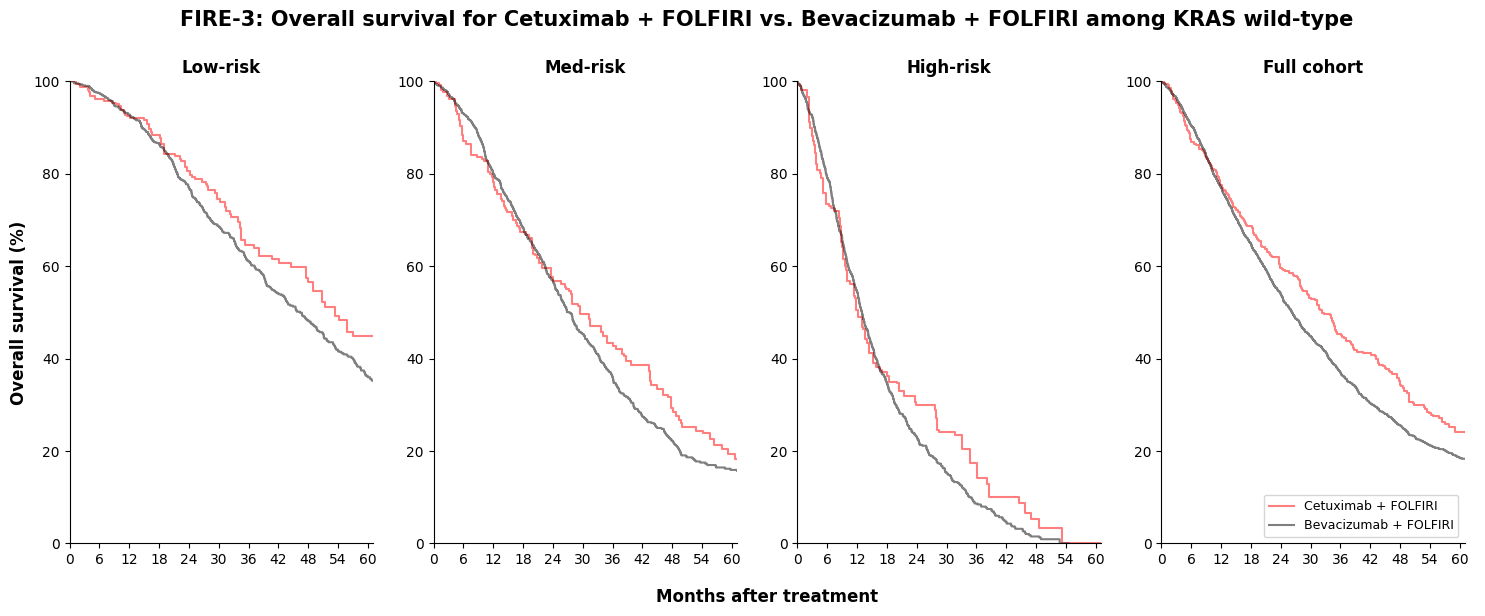

In [147]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_cet_f_iptw.timeline, kmf_low_cet_f_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_low_bev_f_iptw.timeline, kmf_low_bev_f_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Overall survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_cet_f_iptw.timeline, kmf_med_cet_f_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_med_bev_f_iptw.timeline, kmf_med_bev_f_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_cet_f_iptw.timeline, kmf_high_cet_f_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_high_bev_f_iptw.timeline, kmf_high_bev_f_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_cet_f_iptw.timeline, kmf_all_cet_f_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Cetuximab + FOLFIRI')

plt.step(kmf_all_bev_f_iptw.timeline, kmf_all_bev_f_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Bevacizumab + FOLFIRI')

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'lower right', prop = {'size': 9})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('FIRE-3: Overall survival for Cetuximab + FOLFIRI vs. Bevacizumab + FOLFIRI among KRAS wild-type', pad = 40, size = 15, weight = 'bold')

plt.show()